In [62]:
#Import all used libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import yfinance as yf
import datetime
import time
import requests
import io
from fbprophet import Prophet
import holidays
from IPython.display import display_html

#dates for dataset
date1=pd.date_range('04-01-2017', '05-31-2020')

In [63]:
#Define holidays to be used in Prophet
holidays_df = pd.DataFrame([], columns = ['ds','holiday'])
ldates = []
lnames = []
for date, name in sorted(holidays.US(years=np.arange(2017, 2020 + 1)).items()):
    ldates.append(date)
    lnames.append(name)
ldates = np.array(ldates)
lnames = np.array(lnames)
holidays_df.loc[:,'ds'] = ldates
holidays_df.loc[:,'holiday'] = lnames
holidays_df.holiday.unique()
holidays_df.loc[:,'holiday'] = holidays_df.loc[:,'holiday'].apply(lambda x : x.replace(' (Observed)',''))


# Start preprocessing

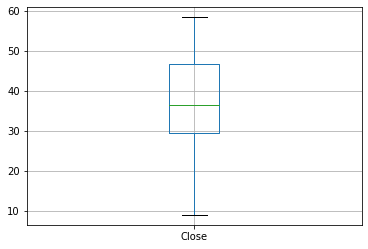

In [67]:
#AA STOCK
Stock = pd.read_csv('AAL.csv')
Stock['Date']=pd.to_datetime(Stock['Date'])
#Fill missing values
Stock=Stock.set_index('Date').reindex(date1)
Stock=Stock.interpolate()
Stock=Stock.fillna(method='bfill')
#Save to csv file
data={'Date': date1,
      'Close': Stock["Close"]}
aastock=pd.DataFrame(data, columns=['Date', 'Close'])
aastock.to_csv(path_or_buf=r'aaStock.csv', index=False)
#AA boxplot
boxplot=aastock.boxplot(column=['Close'])

([<matplotlib.axis.XTick at 0x17bc654eee0>,
 [Text(0, 0, 'Delta'),
  Text(0, 0, 'United'),
  Text(0, 0, 'Southwest'),
  Text(0, 0, 'Mean')])

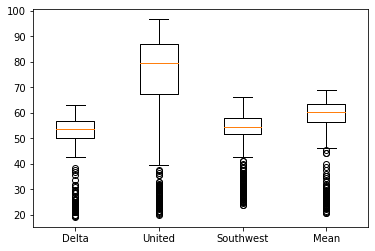

In [68]:
#MEAN STOCKS
Delta = pd.read_csv('DAL.csv')
Southwest= pd.read_csv('LUV.csv')
United= pd.read_csv('UAL.csv')
Delta['Date']=pd.to_datetime(Delta['Date'])
Southwest['Date']=pd.to_datetime(Southwest['Date'])
United['Date']=pd.to_datetime(United['Date'])

#Fill missing values
Southwest=Southwest.set_index('Date').reindex(date1)
Southwest=Southwest.interpolate()
Southwest=Southwest.fillna(method='bfill')
Delta=Delta.set_index('Date').reindex(date1)
Delta=Delta.interpolate()
Delta=Delta.fillna(method='bfill')
United=United.set_index('Date').reindex(date1)
United=United.interpolate()
United=United.fillna(method='bfill')

#Calculate mean stocks
close_d=Delta['Close']
close_s=Southwest['Close']
close_u=United['Close']
mean_stocks=np.zeros(len(close_d))
for i in range(len(close_d)):
    mean_stocks[i]=(close_d[i]*2+close_s[i]+close_u[i])/4
    
#Save to csv file
data={'Date': date1,
      'Close': mean_stocks}
comp_stocks=pd.DataFrame(data, columns=['Date', 'Close'])
comp_stocks.to_csv(path_or_buf=r'comp_stocks.csv', index=False)

#Competition boxplot
plt.boxplot([Delta["Close"], United["Close"], Southwest["Close"], comp_stocks["Close"]])
plt.xticks([1,2,3,4], ['Delta', 'United', 'Southwest', 'Mean'])

In [87]:
#FUEL
#Import until 1st of June in order to have interpolated values for May.
date_fuel=pd.date_range('04-01-2017', '06-01-2020')
fuel= pd.read_csv('Fuel_prices.csv')
fuel["Month"]=fuel['Month'].astype(str)
fuel["Month"]=pd.to_datetime(fuel["Month"])
fuel1=fuel.set_index('Month').reindex(date_fuel)
fuel1=fuel1.interpolate()

#Actual dataset to be used saved
fuel1=fuel1[:1157]
data={'Date': date1,
      'Price': fuel1['Price']}
fuel_price=pd.DataFrame(data, columns=['Date', 'Price'])
fuel_price.to_csv(path_or_buf=r'fuel_price.csv', index=False)

([<matplotlib.axis.XTick at 0x17bc7015280>], [Text(0, 0, 'Passengers')])

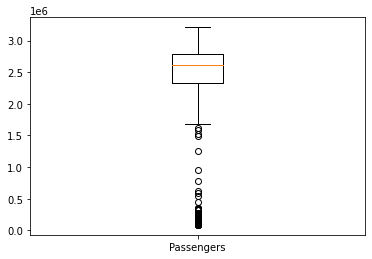

In [127]:
#PASSENGERS
Passengers=pd.read_csv('Passengers.csv')
date_pass=pd.date_range('03-01-2019', '12-31-2020')
m = Prophet(holidays=holidays_df,
            seasonality_mode='multiplicative',
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False)
#Function to split data
def train_test_split(data):
    
    train = data.set_index('Date').loc['2019-03-01':'2020-01-11', :].reset_index()
    train=train.rename(columns={"Date":"ds", "Passengers":"y"})
    test = data.set_index('Date').loc['2020-01-12':'2020-02-29', :].reset_index()
    test=test.rename(columns={'Date':'ds', 'Passengers':'y'})
    return train, test

#Fit, predict and add to dataset
train, test = train_test_split(data=Passengers)
m.fit(train)
y_pred=m.predict(test)
future = m.make_future_dataframe(periods=len(test), freq='1D')
forecast=m.predict(future)
#fi1=m.plot_components(forecast) #Uncomment to see forecast
Passengers1=Passengers
for i in range(48):
    Passengers1.loc[317+i, 'Passengers']=forecast.loc[317+i,'yhat']
Passengers1["Date"]=pd.to_datetime(Passengers1["Date"])
Passengers1=Passengers1.set_index('Date').reindex(date1).reset_index()

#Account for dates until 1/3/2019 with other data
date_prev=pd.date_range('04-01-2017', '02-28-2019')
pass_prev=pd.read_csv('pass_prev.csv')
pass_prev["Date"]=pd.to_datetime(pass_prev[['Year', 'Month']].assign(DAY=1))
pass_prev=pass_prev.set_index('Date').reindex(date_prev).reset_index()
pass_prev=pass_prev.fillna(method='ffill')
pass_prev["Passengers"]=pass_prev["TOTAL"]/30
for i in range(699):
    Passengers1.loc[i, 'Passengers']=pass_prev.loc[i,'Passengers']
Passengers1=Passengers1.interpolate()

#Write to database
data={'Date': date1,
      'Passengers': Passengers1['Passengers']}
passeng=pd.DataFrame(data, columns=['Date', 'Passengers'])
passeng.to_csv(path_or_buf=r'pass_prep.csv', index=False)

#Passenger boxplot
plt.boxplot(passeng["Passengers"])
plt.xticks([1], ['Passengers'])

Text(0.5, 0, 'Date')

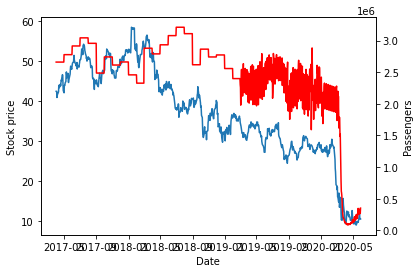

In [128]:
#Plot passengers vs AA stock
fig, ax1=plt.subplots()
ax1.plot(date1, aastock['Close'])
plt.ylabel("Stock price")
plt.xlabel("Date")
ax2 = ax1.twinx()
ax2.plot(date1,Passengers1['Passengers'], c='r')
plt.ylabel("Passengers")
plt.xlabel("Date")

In [100]:
#Unite all in one dataset
aa=pd.read_csv('aaStock.csv')
fuel= pd.read_csv('fuel_price.csv')
comp_stocks=pd.read_csv('comp_stocks.csv')
comp_stocks['Date']=pd.to_datetime(comp_stocks['Date'])
Passengers=pd.read_csv('pass_prep.csv')
Passengers['Date']=pd.to_datetime(Passengers['Date'])

#Variables to help 
aa1=aa[:1126]
fuel1=fuel[:1126]
comp_stocks1=comp_stocks[:1126]
Passengers1=Passengers[:1126]
date2=pd.date_range('04-01-2017', '04-30-2020')

#Dataset with everything
data={'Date': date1,
      'AA': aa["Close"],
      'mean_stocks': comp_stocks["Close"],
       'fuel': fuel["Price"],
         'Passengers': Passengers["Passengers"]}
df=pd.DataFrame(data, columns=['Date', 'AA', 'mean_stocks', 'fuel', 'Passengers'])
df.to_csv(path_or_buf=r'dataset.csv', index=False)

# Data exploration starts

In [101]:
#Start
df=pd.read_csv('dataset.csv')

,Date,AA,mean_stocks,fuel,Passengers
0,2017-04-01,42.450001,54.497499,1.510000,2.659518e+06
1,2017-04-02,42.450001,54.497499,1.506667,2.659518e+06
2,2017-04-03,42.450001,54.497499,1.503333,2.659518e+06
3,2017-04-04,40.900002,53.262501,1.500000,2.659518e+06
4,2017-04-05,41.310001,53.392500,1.496667,2.659518e+06
...,...,...,...,...,...
1152,2020-05-27,11.980000,29.247500,0.933226,2.611700e+05
1153,2020-05-28,10.980000,28.190000,0.942581,3.217760e+05
1154,2020-05-29,10.500000,27.639999,0.951935,3.271330e+05
1155,2020-05-30,10.500000,27.639999,0.961290,2.688670e+05


Text(0, 0.5, 'Price')

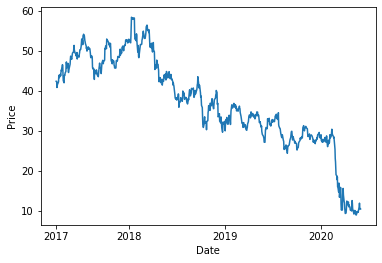

In [11]:
#AA historical prices
ticks=['2017-04-01', '2018-01-01', '2019-01-01', '2020-01-01']
ticks=pd.to_datetime(ticks)
fig, ax1=plt.subplots()
ax1.plot(date1, df["AA"])
plt.xticks(ticks, [2017, 2018, 2019, 2020])
plt.xlabel("Date")
plt.ylabel("Price")

In [12]:
#Forecast AA
from fbprophet import Prophet
import holidays
holidays_df = pd.DataFrame([], columns = ['ds','holiday'])
ldates = []
lnames = []
for date, name in sorted(holidays.US(years=np.arange(2017, 2020 + 1)).items()):
    ldates.append(date)
    lnames.append(name)
    
ldates = np.array(ldates)
lnames = np.array(lnames)
holidays_df.loc[:,'ds'] = ldates
holidays_df.loc[:,'holiday'] = lnames
holidays_df.holiday.unique()
holidays_df.loc[:,'holiday'] = holidays_df.loc[:,'holiday'].apply(lambda x : x.replace(' (Observed)',''))

m = Prophet(holidays=holidays_df,
            seasonality_mode='multiplicative',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False)
aa=aa.rename(columns={"Date":"ds", "Close":"y"})
m.fit(aa)
future = m.make_future_dataframe(periods=len(test), freq='1D')
forecast=m.predict(future)
#fi1=m.plot_components(forecast) #Uncomment to display forecast

Text(0, 0.5, 'Price competition')

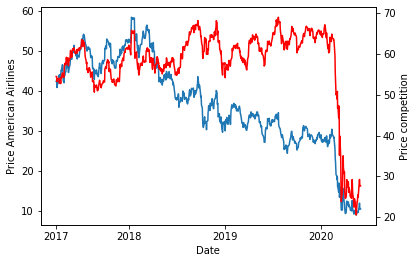

In [13]:
#AA vs Competition
ticks=['2017-04-01', '2018-01-01', '2019-01-01', '2020-01-01']
ticks=pd.to_datetime(ticks)
fig, ax1=plt.subplots()
ax1.plot(date1, df["AA"])
plt.xticks(ticks, [2017, 2018, 2019, 2020])
plt.ylabel("Price American Airlines")
plt.xlabel("Date")
ax2 = ax1.twinx()
ax2.plot(date1,df["mean_stocks"], c='r')
plt.xticks(ticks, [2017, 2018, 2019, 2020])
plt.xlabel("Date")
plt.ylabel("Price competition")

Text(0, 0.5, 'Fuel price ($)')

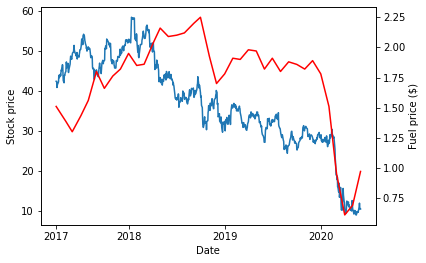

In [15]:
#AA vs fuel prices
ticks=['2017-04-01', '2018-01-01', '2019-01-01', '2020-01-01']
ticks=pd.to_datetime(ticks)
fig, ax1=plt.subplots()
ax1.plot(date1, df['AA'])
plt.xlabel('Date')
plt.ylabel('Stock price')
ax2 = ax1.twinx()
ax2.plot(date1,df['fuel'], c='r')
plt.xticks(ticks, [2017, 2018, 2019, 2020])
plt.xlabel('Date')
plt.ylabel('Fuel price ($)')

([<matplotlib.axis.XTick at 0x17bc6097610>,
 [Text(0, 0, '2017'),
  Text(0, 0, '2018'),
  Text(0, 0, '2019'),
  Text(0, 0, '2020')])

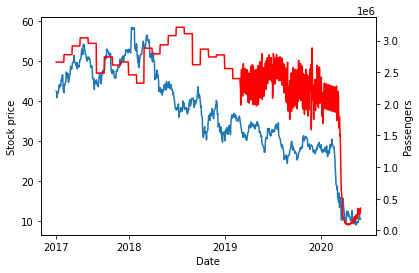

In [16]:
#AA vs Passengers
df["Date"]=pd.to_datetime(df["Date"])
fig, ax1=plt.subplots()
ax1.plot(df["Date"], df['AA'])
plt.ylabel("Stock price")
plt.xlabel("Date")
ax2 = ax1.twinx()
ax2.plot(df["Date"],df['Passengers'], c='r')
plt.ylabel("Passengers")
plt.xlabel("Date")
plt.xticks(ticks, [2017, 2018, 2019, 2020])

In [17]:
#Scatter plots
def met(Y):
    X=df["AA"]
    fig=plt.subplots()
    plt.scatter(X,Y)
    plt.xlabel("Fuel price")
    plt.ylabel("AA stock price")
    result = pearsonr(X,Y)
    print(result)
    result_sp=spearmanr(X,Y)
    print(result_sp)

#uncomment electively to see stats for every variable
#print("passengers:")
#met(df["Passengers"])
#print("fuel:")
#met(df["fuel"])
#print("Competition stocks:")
#met(df["mean_stocks"])

 Every variable will be inferred from its own time series, and then computed on a dataset with its previous values

In [28]:
#Account for effect of pandemic in 2020
def is_pandemic_affected(ds):
    date = pd.to_datetime(ds)
    return (date.year == 2020) 

#Account for effect of pandemic since March 2020
def is_fall(ds):
    date = pd.to_datetime(ds)
    return (date.year == 2020) and (date.month>=3)

#Time series estimation of variables: comp_stocks, passengers and fuel prices
def infer_var(var, holiday, y,w):
    df=pd.read_csv('dataset.csv')
    df=df.rename(columns={"Date":"ds"})
    df_covid = df.copy()
    df_covid=df_covid.rename(columns={var:"y"})   
    #Add columns if affected by seasonality
    df_covid['pandemic_affected'] = df_covid['ds'].apply(is_pandemic_affected)
    df_covid['not_pandemic_affected'] = ~df_covid['ds'].apply(is_pandemic_affected)
    df_covid['fall'] = df_covid['ds'].apply(is_fall)
    df_covid['not_fall'] = ~df_covid['ds'].apply(is_fall)
    
    #Model
    if (holiday==True):
        m = Prophet(holidays=holidays_df,
            seasonality_mode='multiplicative',
            yearly_seasonality=False,
            weekly_seasonality=w,
            daily_seasonality=False)
    else:
        m = Prophet(
            seasonality_mode='multiplicative',
            yearly_seasonality=False,
            weekly_seasonality=w,
            daily_seasonality=False)
    m.add_seasonality(name='pandemic_affected', period=365, fourier_order=1, mode='multiplicative', condition_name='pandemic_affected')
    m.add_seasonality(name='not_pandemic_affected', period=365, fourier_order=1, mode='multiplicative', condition_name='not_pandemic_affected')
    if (y==True):
        m.add_seasonality(name='fall', period=365, fourier_order=1, mode='multiplicative', condition_name='fall')
        m.add_seasonality(name='not_fall', period=365, fourier_order=1, mode='multiplicative', condition_name='not_fall')
    
    #Train and fit
    train=df_covid[:1126]
    test=df_covid[1126:1157]
    m.fit(train)
    future=m.make_future_dataframe(periods=len(test))
    #Add columns of affected by seasonality
    future['pandemic_affected'] = future['ds'].apply(is_pandemic_affected)
    future['not_pandemic_affected'] = ~future['ds'].apply(is_pandemic_affected)
    future['fall'] = future['ds'].apply(is_fall)
    future['not_fall'] = ~future['ds'].apply(is_fall)
    forecast=m.predict(future)
    fig1 = m.plot(forecast)
    test["ds"]=pd.to_datetime(test["ds"])
    forecast1=forecast[1126:1157]
    
    #Plot predicted variable vs actual values
    fig, ax1=plt.subplots()
    ax1.plot(test["ds"],test["y"], label="Real values" )
    ax1.plot(test["ds"],forecast1["yhat"], c='r', label="Estimate")
    ax1.legend()
    plt.xlabel("Date")
    plt.ylabel("Price")
    
    return forecast1

<ipython-input-28-6051ee45b4c6>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["ds"]=pd.to_datetime(test["ds"])
<ipython-input-28-6051ee45b4c6>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["ds"]=pd.to_datetime(test["ds"])
<ipython-input-28-6051ee45b4c6>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

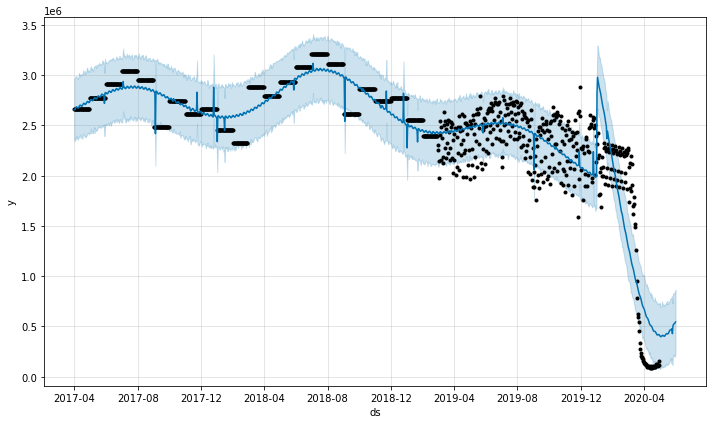

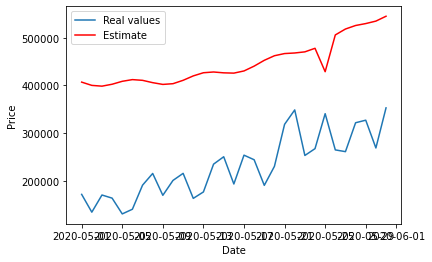

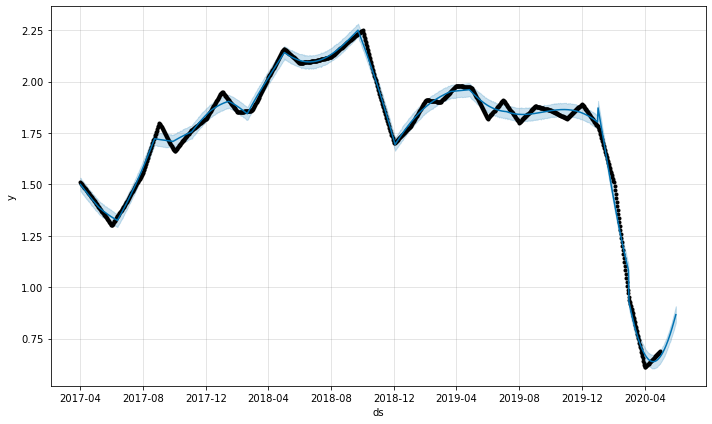

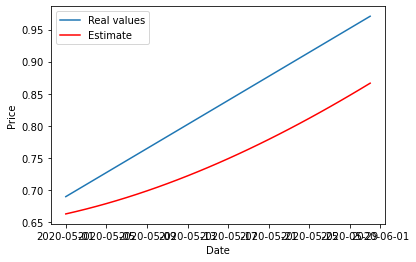

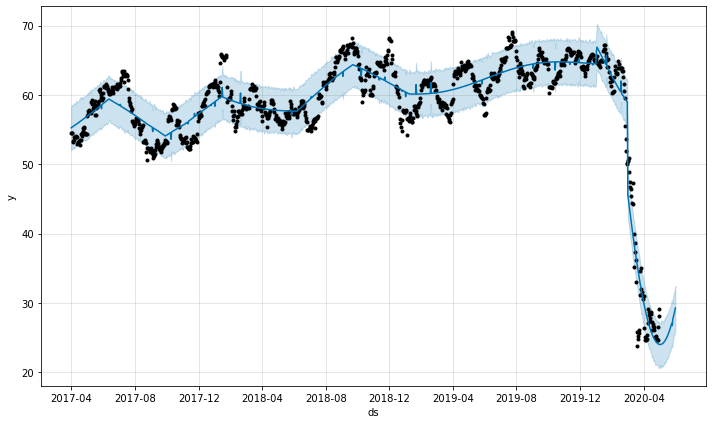

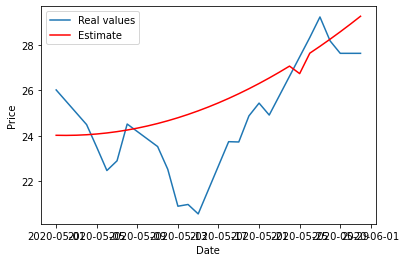

In [61]:
df=pd.read_csv('dataset.csv')

#Form forecast dataset to link to df
forecasts=pd.DataFrame()
pass_y=infer_var("Passengers",1,0,1)
fuel_y=infer_var("fuel",0,1,0)
stocks_y=infer_var("mean_stocks",1,1,0)

forecasts["Date"]=pass_y["ds"]
forecasts["fuel"]=fuel_y["yhat"]
forecasts["mean_stocks"]=stocks_y["yhat"]
forecasts["Passengers"]=pass_y["yhat"]
forecasts["y"]=float("nan")

#concat both datasets
for i in range(len(forecasts)):
    df.loc[i+1126]=forecasts.loc[i+1126]
df.to_csv(path_or_buf=r'est_dataset.csv', index=False)


# Data inference

In [51]:
def data_inference(Model):
    #Add both datasets, one with true values and other with estimated
    df_est=pd.read_csv('est_dataset.csv')
    df=pd.read_csv('dataset.csv')
    df_est["Date"]=pd.to_datetime(df_est["Date"])
    df["Date"]=pd.to_datetime(df["Date"])
    df_est=df_est.rename(columns={"Date":"ds", "AA":"y"})
    df=df.rename(columns={"Date":"ds", "AA":"y"})

    #Add columns if affected by pandemic seasonality
    df_est['pandemic_affected'] = df_est['ds'].apply(is_pandemic_affected)
    df_est['not_pandemic_affected'] = ~df_est['ds'].apply(is_pandemic_affected)
    df_est['fall'] = df_est['ds'].apply(is_fall)
    df_est['not_fall'] = ~df_est['ds'].apply(is_fall)

    #Method
    m = Prophet(holidays=holidays_df,
            seasonality_mode='multiplicative',
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False)
    #Only add other variables and seasonality if second model
    if (Model==2):
        m.add_regressor('fuel', mode='multiplicative')
        m.add_regressor('mean_stocks', mode='multiplicative')
        m.add_regressor('Passengers', mode='multiplicative')
        m.add_seasonality(name='pandemic_affected', period=365, fourier_order=2, mode='multiplicative', condition_name='pandemic_affected')
        m.add_seasonality(name='not_pandemic_affected', period=365, fourier_order=2, mode='multiplicative', condition_name='not_pandemic_affected')
        m.add_seasonality(name='fall', period=365, fourier_order=2, mode='multiplicative', condition_name='fall')
        m.add_seasonality(name='not_fall', period=365, fourier_order=2, mode='multiplicative', condition_name='not_fall')
    
    #Train and test model
    train=df_est[:1126]
    test=df_est[1126:1157]
    real_test=df[1126:1157]
    m.fit(train)
    y_pred=m.predict(test)
    return real_test, y_pred, test



In [52]:
#Obtain inferred data
real_test, Model1, test=data_inference(1)
real_test, Model2, test=data_inference(2)

Text(0, 0.5, 'Price')

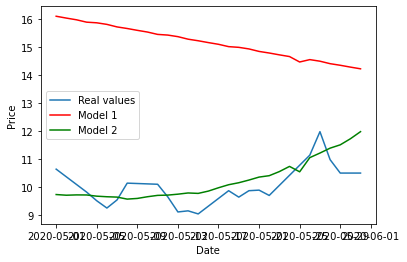

In [53]:
#Plot both sets of data
fig, ax1=plt.subplots()
ax1.plot(test["ds"],real_test["y"], label="Real values" )
ax1.plot(test["ds"], Model1["yhat"], c='r', label="Model 1")
ax1.plot(test["ds"], Model1["yhat_upper"], 'r--')
ax1.plot(test["ds"], Model1["yhat_lower"], 'r--')
ax1.plot(test["ds"],Model2["yhat"], c='g', label="Model 2")
ax1.plot(test["ds"], Model2["yhat_upper"], 'g--')
ax1.plot(test["ds"], Model2["yhat_lower"], 'g--')
ax1.legend()
plt.xlabel("Date")
plt.ylabel("Price")

In [54]:
#Metrics
def get_metrics(Model, real_test):
    x1=mean_squared_error(real_test["y"], Model["yhat"])
    x2=mean_absolute_error(real_test["y"], Model["yhat"])
    x3=r2_score(real_test["y"], Model["yhat"])
    print("Mean squared error=", x1)
    print("Mean absolute error=", x2)
    print("R squared=", x3)
    Model["yhat"]=Model["yhat"].dropna()
    real_test=real_test.reset_index()
    residuals=real_test["y"]-Model["yhat"]
    residuals
    print(residuals.mean())
    print(residuals.median())
    print(residuals.skew())
 
#Uncomment selectively to see metrics
#get_metrics(Model1)
#get_metrics(Model2, real_test)

Mean squared error= 0.3684280826393812
Mean absolute error= 0.5151449034796457
R squared= 0.10567591540495624
-0.18674892661914647
-0.3182912890878171
-0.02621349264133192
